In [323]:
import numpy as np
import matplotlib.pyplot as plt

In [324]:
freq_tmr = 84e6     #[Hz]
full_step = 1.8      #[deg/step]
micro_steps = 1/8

alpha = full_step * micro_steps #[deg/pulse]
alpha_rad = (alpha * np.pi/180)

t_scaler = freq_tmr # t itt a szokásosan 'y' tengely, hiszen inverz fgv-t nézünk
theta_scaler = 1e6

In [325]:
def test_numeric_method(func, title, funcArgs = None, theta_scaler = theta_scaler):
    x_vals_test = np.linspace(-theta_scaler,theta_scaler,1000)
    y_vals_test = list()

    if funcArgs:
        for x in x_vals_test:
            y_vals_test.append(func(x, funcArgs))
    else:
        for x in x_vals_test:
            y_vals_test.append(func(x))

    plt.plot(x_vals_test,y_vals_test)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('~ -arcsin(x)')
    plt.grid()

In [326]:
def generate_neg_arcsin_LUT__scaled(N, y_scaler = t_scaler, x_scaler = theta_scaler):
    x_vals = np.linspace(0,1,N)
    y_vals = -np.arcsin(x_vals)
    return x_vals*x_scaler, y_vals*y_scaler

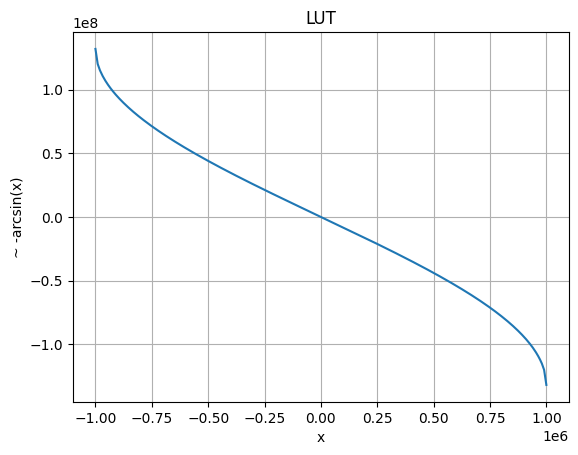

In [327]:
def interpolate_from_LUT(x, LUT):
    x_vals = LUT[0]
    y_vals = LUT[1]

    sign = 1

    if x < 0:
        sign = -1
        x = -x
    
    if x <= x_vals[0]:
        return sign * y_vals[0]
    elif x >= x_vals[-1]:
        return sign * y_vals[-1]
    
    idx = np.searchsorted(x_vals, x) - 1
    x0, x1 = x_vals[idx], x_vals[idx+1]
    y0, y1 = y_vals[idx], y_vals[idx+1]
    
    #linear approximation

    dy_dx = (y1 - y0) / (x1 - x0)
    dt = x - x0
    y = y0 + (dy_dx * dt)

    return sign * y

LUT_TEST = generate_neg_arcsin_LUT__scaled(100)
test_numeric_method(interpolate_from_LUT, title = 'LUT', funcArgs = LUT_TEST)

In [328]:
def calculate_tk_scaled(arcsin_approx, LUT, k, Theta_rad, T, alpha_rad, theta_scaler = theta_scaler, t_scaler = t_scaler):
    """
    arcsin_approx: LUT-alapú arcsin közelítés
    LUT: skálázott LUT (x, y) értékek
    k: lépés index
    Theta_rad: teljes lépésszög (radián)
    T: teljes periódusidő (sec)
    alpha_rad: lépésköz (radián)
    y_scaler: arcsin LUT skálázó (pl. 84e6)
    freq_tmr: timer frekvencia
    """

    # felskálázott idő (ez az y tengely)
    T_scaled = T * t_scaler

    # felskálázott pi
    pi_scaled = np.pi * t_scaler

    # alpha_rad skálázása
    alpha_rad_scaled = alpha_rad * theta_scaler

    # Theta skálázása

    Theta_rad_scaled = Theta_rad * theta_scaler


    neg_arcsin_arg_scaled = 1 * theta_scaler - 2 * theta_scaler * (k * alpha_rad_scaled) / (Theta_rad_scaled)

    # Skálázott arcsin érték lekérése
    neg_arcsin_scaled = arcsin_approx(neg_arcsin_arg_scaled, LUT)


    # Skálázott t_k
    tk_scaled = (neg_arcsin_scaled + pi_scaled/2) * T_scaled / pi_scaled 

    return tk_scaled

In [329]:
print(1e8)

100000000.0


In [330]:
Theta = 90          #[deg]
T = 2

n_steps = int(Theta/alpha)
Theta_rad = np.deg2rad(Theta)


LUT_res = 10000
LUT = generate_neg_arcsin_LUT__scaled(LUT_res)

times_scaled = []

for k in range(n_steps+1):
    t_k_scaled = calculate_tk_scaled(interpolate_from_LUT, LUT, k, Theta_rad, T, alpha_rad)

    times_scaled.append(t_k_scaled)

print(times_scaled[k])

d_times_scaled = np.diff(times_scaled)

d_times_summed_LUT = [] # to check the theory

integrated_speed_LUT = []

# speed in rad/sec
speed_LUT = alpha_rad / d_times_scaled

#sum for LUT
sum = 0
sum_int = 0
for dt in d_times_scaled:
    sum += dt
    d_times_summed_LUT.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_LUT.append(sum_int)

168000000.0


In [331]:
def T_omega_texts(ax1: plt.axes, ax2: plt.axes, times: np.array, omegas: np.array, thetas: np.array, d_times_summed: np.array) -> None:
    T_text = r"$T= $" + f"{np.round(np.nanmax(times), 3)}" + r" $[s]$"
    ax1.text(np.nanmax(times) - 0.09, np.nanmax(thetas)/2, 
            T_text,
            ha = 'right',
            va = 'center',
            rotation = 'vertical',
            bbox=dict(facecolor='red', alpha=0.3, boxstyle = 'round', ec = 'red')
            )

    omega_max_text = r"$\omega_{max} = $" + f"{np.round(np.nanmax(omegas), 3)}" + r" $[\frac{rad}{s}]$"
    ax2.text(np.nanmax(d_times_summed)/2, np.nanmax(omegas)+0.07, 
            omega_max_text,
            ha = 'center',
            bbox=dict(facecolor='blue', alpha=0.3, boxstyle = 'round', ec = 'blue')
            )

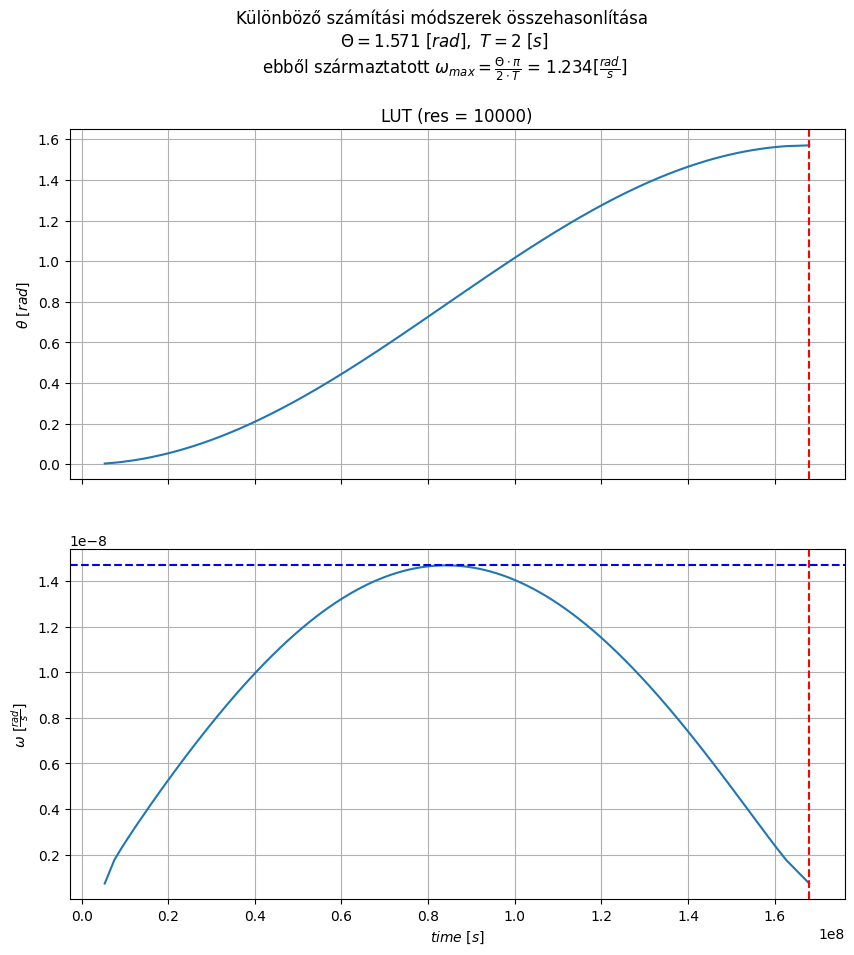

In [332]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)


omega_max_calculated = (Theta_rad * np.pi )/( 2 * T )

title = "Különböző számítási módszerek összehasonlítása \n" + \
        fr"$\Theta = {np.round(Theta_rad, 3)} \ [rad], \ T = {T} \ [s]$" + "\n" + \
        r"ebből származtatott $\omega_{max} = \frac{\Theta \cdot \pi}{2 \cdot T}$" + f" = {np.round(omega_max_calculated, 3)}" + r"$[\frac{rad}{s}]$"

fig.suptitle(title, y = 1)

fig.set_size_inches(10,10)
#fig.set_dpi(700)



ax1.plot(d_times_summed_LUT, integrated_speed_LUT)
ax2.plot(d_times_summed_LUT, speed_LUT)

ax2.axhline(speed_LUT.max(), color = 'blue', ls = '--')
ax1.axvline(d_times_summed_LUT[-1], color = 'red', ls = '--')
ax2.axvline(d_times_summed_LUT[-1], color = 'red', ls = '--')

#T_omega_texts(ax1, ax2, d_times_summed_LUT, speed_LUT, integrated_speed_LUT, d_times_summed_LUT)
ax1.set_title(f"LUT (res = {LUT_res})")

ax1.set_ylabel(r'$\theta\ [rad]$')
ax2.set_ylabel(r'$\omega\ [\frac{rad}{s}]$')

for ax in fig.get_axes():
    ax.grid()
    ax.set_xlabel(r'$time\ [s]$')
    ax.label_outer()

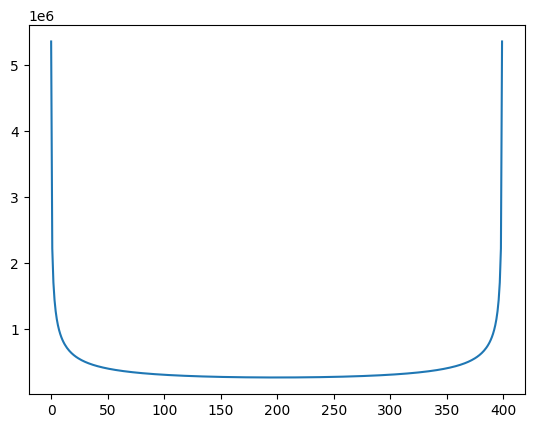

In [333]:
ARR_vals = ( (d_times_scaled / t_scaler) *freq_tmr)-1

plt.plot(ARR_vals)